# 1) Load + drop non-wearable columns

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

downloaded_publicdata = pd.read_csv("stress_factors.csv")  # change filename

# columns to drop as inputs (survey-only / subjective). Keep if you want as metadata separately.
drop_cols = [
 'blood_pressure','breathing_problem','mental_health_history',
 'extracurricular_activities',
 'bullying','safety','stress_level'
]

for c in drop_cols:
    if c in downloaded_publicdata.columns:
        downloaded_publicdata = downloaded_publicdata.drop(columns=c)
        
print("Remaining columns:", downloaded_publicdata.columns.tolist())

import numpy as np

downloaded_publicdata = pd.read_csv('stress_factors.csv')

np.random.seed(42)
# Adding new columns
downloaded_publicdata['Age'] = np.random.randint(18, 26, size=len(downloaded_publicdata))
downloaded_publicdata['Gender'] = np.random.choice(['Male', 'Female'], size=len(downloaded_publicdata))
downloaded_publicdata['Year of Study'] = np.random.choice(['First Year', 'Second Year', 'Third Year', 'Fourth Year'], size=len(downloaded_publicdata))
disciplines = ['IT/CS/Software/AI', 'Natural Sciences/Social Sciences', 'Civil/Mechanical Engineering', 'Business Administration']
downloaded_publicdata['Discipline/Field'] = np.random.choice(disciplines, size =len(downloaded_publicdata))
desired_order = [
    'Age', 'Gender', 'Year of Study', 'Discipline/Field',
    'anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 
    'noise_level', 'living_conditions', 'basic_needs','academic_performance',
    'study_load', 'teacher_student_relationship',
    'future_career_concerns', 'social_support', 'peer_pressure'
]
downloaded_publicdata = downloaded_publicdata[desired_order]
print("Public data after updating")
print(downloaded_publicdata.columns.tolist())
public_data = downloaded_publicdata.copy()

Remaining columns: ['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure']
Public data after updating
['Age', 'Gender', 'Year of Study', 'Discipline/Field', 'anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure']


['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure']
(1100, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   depression                    1100 non-null   int64
 3   headache                      1100 non-null   int64
 4   sleep_quality                 1100 non-null   int64
 5   noise_level                   1100 non-null   int64
 6   living_conditions             1100 non-null   int64
 7   basic_needs                   1100 non-null   int64
 8   academic_performance          1100 non-null   int

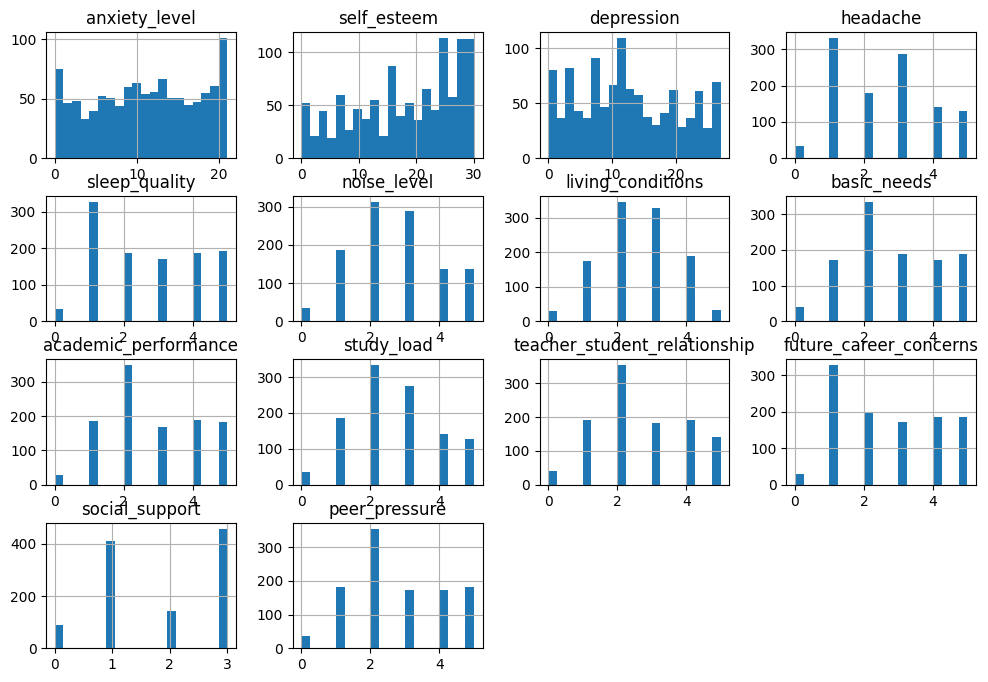

anxiety_level                   0
self_esteem                     0
depression                      0
headache                        0
sleep_quality                   0
noise_level                     0
living_conditions               0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
dtype: int64


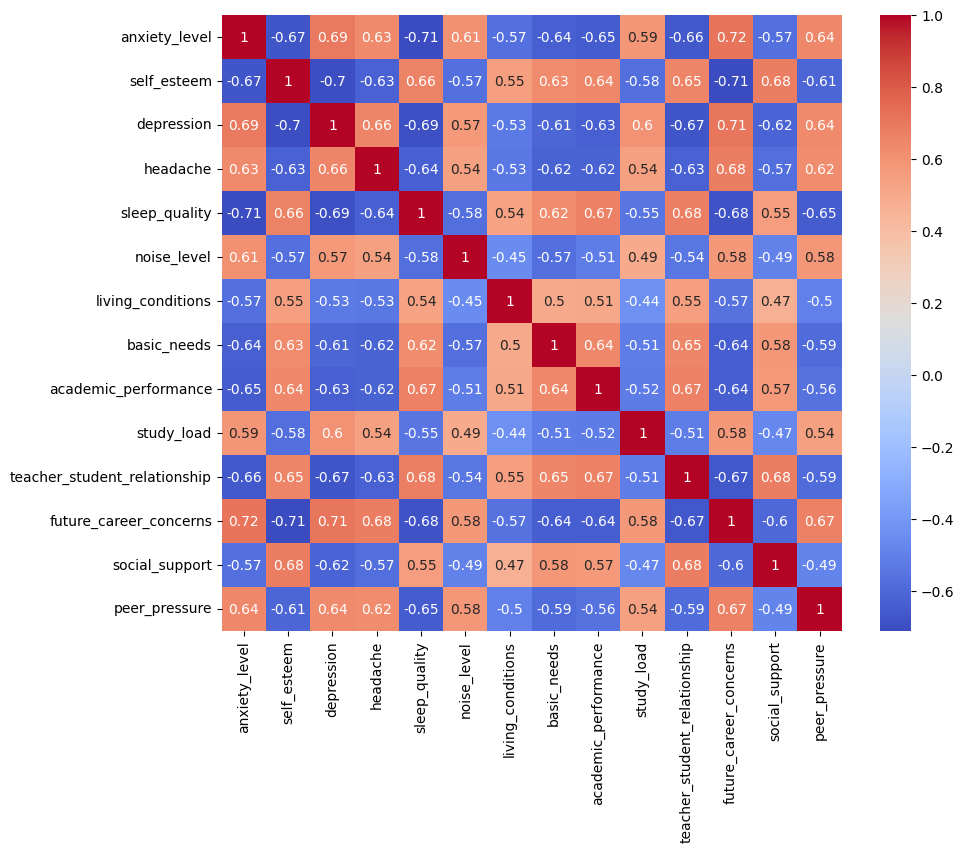

<Figure size 1000x800 with 0 Axes>

In [2]:
# Data Visualization-Exploratory Data Analysis EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

public_data = downloaded_publicdata.copy()

public_data = public_data.drop(columns=['Timestamp', 'Age', 'Gender', 'Year of Study', 'Discipline/Field'], errors='ignore')

public_data.to_csv("stressfactors_cleaned.csv", index=False)

print(public_data.columns.tolist())

public_data.head()

print(public_data.shape)
public_data.info()
print(public_data.describe())

print(public_data.isnull().sum())

public_data.hist(bins=20, figsize=(12,8))
plt.show()

print(public_data.isnull().sum())

numeric_data = public_data.select_dtypes(include=['number'])
# sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")

plt.figure(figsize=(10,8))
sns.heatmap(public_data.corr(),annot=True,cmap="coolwarm")

plt.show()

plt.figure(figsize=(10,8))

plt.show()

for col in public_data.columns:
    plt.show()

# 2) Create binary targets (auto, data-driven)

This creates target_psych, target_phys, target_env by aggregating related columns and binarizing using the median of that aggregated score (data-driven).

In [6]:
# # Define groups (adjust if you want different mapping)
# psych_cols = [c for c in ['anxiety_level','self_esteem','depression'] if c in public_data.columns]
# phys_cols  = [c for c in ['headache','sleep_quality'] if c in public_data.columns]
# social_cols  = [c for c in ['social_support','peer_pressure'] if c in public_data.columns]
# env_cols   = [c for c in ['noise_level','living_conditions','basic_needs'] if c in public_data.columns]
# acad_cols  = [c for c in ['academic_performance','study_load','teacher_student_relationship','future_career_concerns'] if c in public_data.columns]

# def make_target(group_cols, name):
#     if not group_cols:
#         return None
#     # compute per-row mean of the group's columns (handles different scales)
#     s = public_data[group_cols].mean(axis=1)
#     thresh = s.median()  # data-driven threshold (you can change to a fixed value)
#     public_data[name] = (s >= thresh).astype(int)
#     return name

# _ = make_target(psych_cols, 'target_psych')
# _ = make_target(phys_cols,  'target_phys')
# _ = make_target(social_cols,  'target_social')
# _ = make_target(env_cols,   'target_env')
# _ = make_target(acad_cols,   'target_acad')

# targets = [c for c in ['target_psych','target_phys','target_social','target_env','target_acad'] if c in public_data.columns]
# print("Targets created:", targets)
# public_data[targets].head()

# Factor Correlation, Feature importance, At-risk percentage

STUDENT WELLBEING FACTOR ANALYSIS

Analyzing 1100 students across 5 wellbeing factors

--- Creating Factor Scores ---
✓ Psychological: 3 variables
✓ Physical: 2 variables
✓ Social: 2 variables
✓ Environmental: 3 variables
✓ Academic: 4 variables

1. FACTOR CORRELATIONS - Understanding Relationships Between Factors

Correlation Matrix:
               Psychological  Physical  Social  Environmental  Academic
Psychological          1.000    -0.104   0.234         -0.214     0.012
Physical              -0.104     1.000  -0.079          0.017     0.082
Social                 0.234    -0.079   1.000         -0.068     0.162
Environmental         -0.214     0.017  -0.068          1.000     0.100
Academic               0.012     0.082   0.162          0.100     1.000


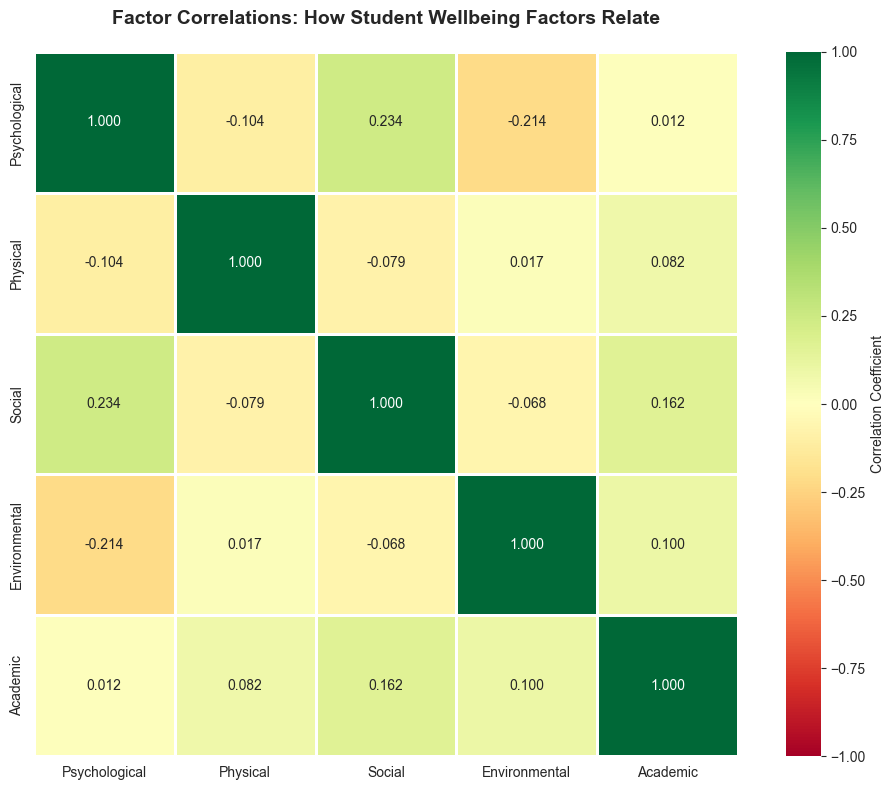


Key Findings:

Strongest Factor Relationships:
  • Psychological ↔ Social: 0.234 (moderate positive)
  • Psychological ↔ Environmental: -0.214 (moderate negative)
  • Social ↔ Academic: 0.162 (moderate positive)

2. FEATURE IMPORTANCE - Which Factors Predict Academic Performance

Training Random Forest model to identify important factors...

Model Performance:
  Training R² Score: 0.801
  Testing R² Score: 0.632

Top 10 Most Important Factors for Academic Performance:
  10. teacher_student_relationship        [Academic] - Importance: 0.4078
  7. self_esteem                         [Psychological] - Importance: 0.1312
  12. headache                            [Physical] - Importance: 0.0719
  2. basic_needs                         [Environmental] - Importance: 0.0715
  5. peer_pressure                       [Social] - Importance: 0.0650
  3. sleep_quality                       [Physical] - Importance: 0.0594
  13. future_career_concerns              [Academic] - Importance: 0.0468
  1.

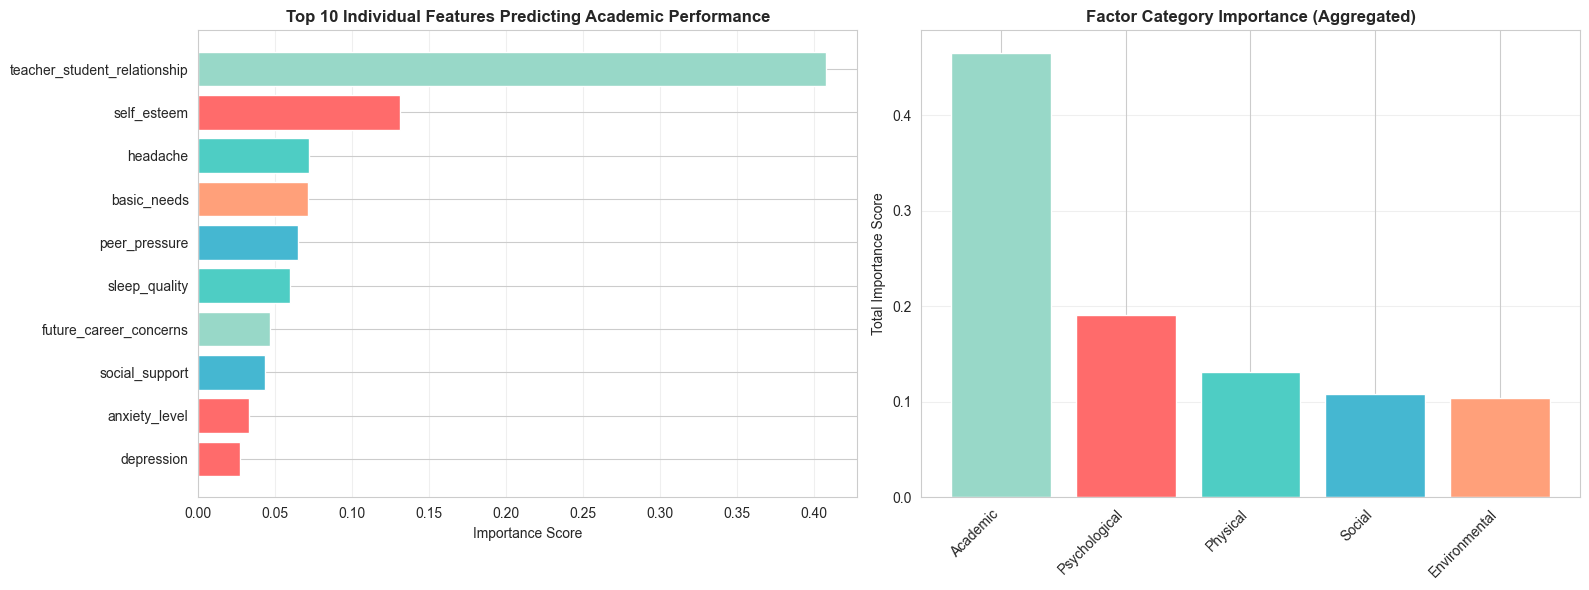


Factor Category Rankings (Total Importance):
  1. Academic: 0.4656
  2. Psychological: 0.1907
  3. Physical: 0.1313
  4. Social: 0.1085
  5. Environmental: 0.1039

3. AT-RISK STUDENT IDENTIFICATION

--- Risk Scoring System ---

Risk Criteria Applied:
  • High Anxiety (>16.00): 264 students
  • High Depression (>19.00): 254 students
  • Low Self-Esteem (<11.00): 267 students
  • Poor Sleep Quality (<1.00): 34 students
  • Low Social Support (<1.00): 88 students
  • Poor Academic Performance (<2.00): 213 students
  • Poor Living Conditions (<2.00): 205 students

--------------------------------------------------------------------------------
AT-RISK STUDENT DISTRIBUTION
--------------------------------------------------------------------------------
       Low Risk:   688 students ( 62.5%)
  Moderate Risk:   283 students ( 25.7%)
      High Risk:   129 students ( 11.7%)

  TOTAL AT-RISK:   412 students ( 37.5%)


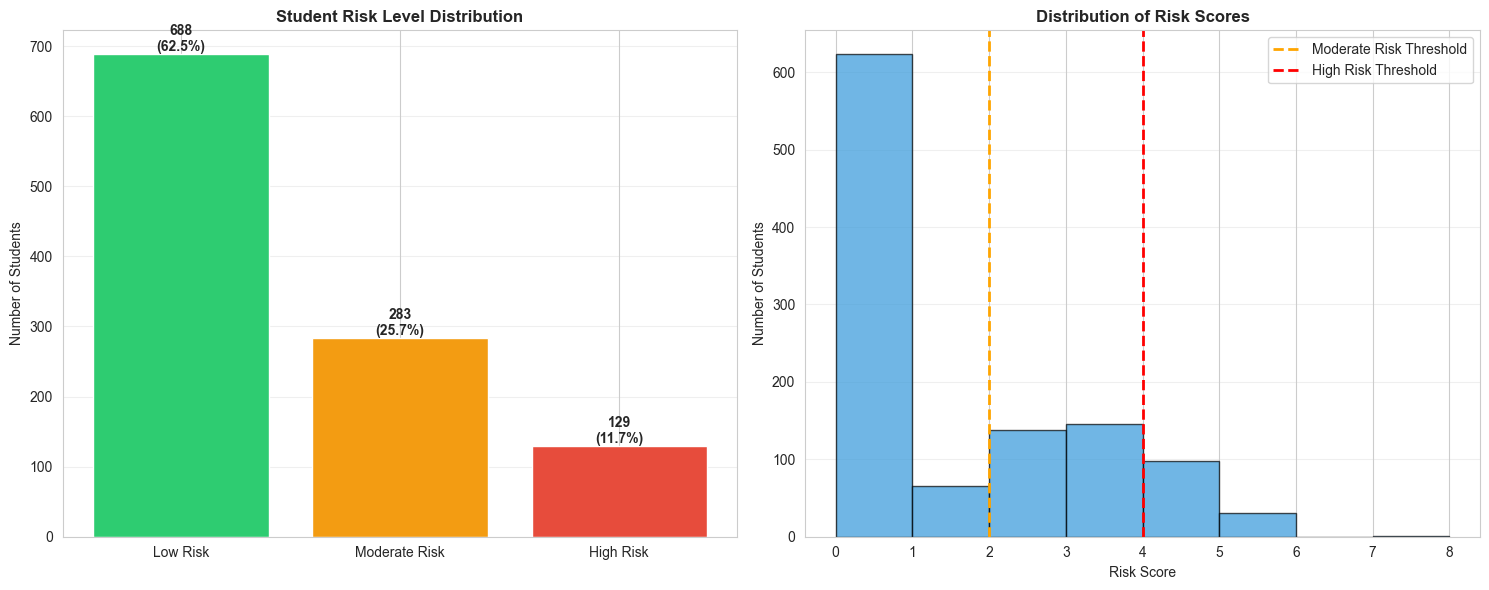


--------------------------------------------------------------------------------
HIGH-RISK STUDENT PROFILE (Average Factor Scores)
--------------------------------------------------------------------------------

Comparing High-Risk (n=129) vs Low-Risk (n=688) students:

  Psychological: High-Risk=15.47, Low-Risk=13.14, Overall=13.80 [↑ HIGHER by 2.33]
  Environmental: High-Risk=2.25, Low-Risk=2.81, Overall=2.65 [↓ LOWER by 0.55]


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Data Preparation

factors = {
    'Psychological': ['anxiety_level', 'self_esteem', 'depression'],
    'Physical': ['headache', 'sleep_quality'],
    'Social': ['social_support', 'peer_pressure'],
    'Environmental': ['noise_level', 'living_conditions', 'basic_needs'],
    'Academic': ['study_load', 'teacher_student_relationship', 'future_career_concerns', 'academic_performance']
}

print("="*80)
print("STUDENT WELLBEING FACTOR ANALYSIS")
print("="*80)
print(f"\nAnalyzing {len(public_data)} students across 5 wellbeing factors")

# Create factor scores (average of variables within each factor)
print("\n--- Creating Factor Scores ---")
for factor_name, cols in factors.items():
    available_cols = [c for c in cols if c in public_data.columns]
    if available_cols:
        public_data[f'factor_{factor_name.lower()}'] = public_data[available_cols].mean(axis=1)
        print(f"✓ {factor_name}: {len(available_cols)} variables")

# Section 2: Factor correlations
print("\n" + "="*80)
print("1. FACTOR CORRELATIONS - Understanding Relationships Between Factors")
print("="*80)

factor_cols = [f'factor_{name.lower()}' for name in factors.keys()]
correlation_matrix = public_data[factor_cols].corr()

# Rename for better readability
correlation_matrix.index = factors.keys()
correlation_matrix.columns = factors.keys()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Visualize correlations
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=2,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Factor Correlations: How Student Wellbeing Factors Relate', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Section 3: Identify strongest relationships
print("\nKey Findings:")
correlations_list = []
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        correlations_list.append({
            'Factor 1': correlation_matrix.index[i],
            'Factor 2': correlation_matrix.columns[j],
            'Correlation': correlation_matrix.iloc[i, j]
        })

correlations_df = pd.DataFrame(correlations_list).sort_values('Correlation', 
                                                                ascending=False, 
                                                                key=abs)
print("\nStrongest Factor Relationships:")
for idx, row in correlations_df.head(3).iterrows():
    strength = "strong" if abs(row['Correlation']) > 0.5 else "moderate"
    direction = "positive" if row['Correlation'] > 0 else "negative"
    print(f"  • {row['Factor 1']} ↔ {row['Factor 2']}: "
          f"{row['Correlation']:.3f} ({strength} {direction})")

# Section 3: Feature importance 
print("\n" + "="*80)
print("2. FEATURE IMPORTANCE - Which Factors Predict Academic Performance")
print("="*80)

# Prepare data for modeling
target = 'academic_performance'
all_features = []
for group in factors.values():
    all_features.extend([c for c in group if c in public_data.columns and c != target])
all_features = list(set(all_features))

# Handle missing values
X = public_data[all_features].fillna(public_data[all_features].median())
y = public_data[target].fillna(public_data[target].median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
print("\nTraining Random Forest model to identify important factors...")
rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10,
                           min_samples_leaf=5, random_state=42)
rf.fit(X_train, y_train)

# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Add factor category to each feature
def get_factor_category(feature_name):
    for category, features in factors.items():
        if feature_name in features:
            return category
    return 'Other'

feature_importance['Factor_Category'] = feature_importance['Feature'].apply(get_factor_category)

print(f"\nModel Performance:")
print(f"  Training R² Score: {rf.score(X_train, y_train):.3f}")
print(f"  Testing R² Score: {rf.score(X_test, y_test):.3f}")

if rf.score(X_test, y_test) < 0.1:
    print("  ⚠️  Warning: Low R² suggests weak predictive relationships")
    print("     Consider: feature engineering, data quality checks, or different target variable")

print("\nTop 10 Most Important Factors for Academic Performance:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {idx+1}. {row['Feature']:<35} "
          f"[{row['Factor_Category']}] - Importance: {row['Importance']:.4f}")

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Individual feature importance
colors = {'Psychological': '#FF6B6B', 'Physical': '#4ECDC4', 
          'Social': '#45B7D1', 'Environmental': '#FFA07A', 'Academic': '#98D8C8'}
feature_colors = [colors.get(cat, 'gray') for cat in feature_importance.head(10)['Factor_Category']]

ax1.barh(range(10), feature_importance.head(10)['Importance'], color=feature_colors)
ax1.set_yticks(range(10))
ax1.set_yticklabels(feature_importance.head(10)['Feature'])
ax1.set_xlabel('Importance Score')
ax1.set_title('Top 10 Individual Features Predicting Academic Performance', 
              fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Factor category importance (aggregated)
category_importance = feature_importance.groupby('Factor_Category')['Importance'].sum().sort_values(ascending=False)
category_colors = [colors.get(cat, 'gray') for cat in category_importance.index]

ax2.bar(range(len(category_importance)), category_importance.values, color=category_colors)
ax2.set_xticks(range(len(category_importance)))
ax2.set_xticklabels(category_importance.index, rotation=45, ha='right')
ax2.set_ylabel('Total Importance Score')
ax2.set_title('Factor Category Importance (Aggregated)', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFactor Category Rankings (Total Importance):")
for rank, (category, importance) in enumerate(category_importance.items(), 1):
    print(f"  {rank}. {category}: {importance:.4f}")

# At-risk percentage
print("\n" + "="*80)
print("3. AT-RISK STUDENT IDENTIFICATION")
print("="*80)

# Method 1: Multi-criteria risk scoring
print("\n--- Risk Scoring System ---")
risk_score = pd.Series(0, index=public_data.index)
risk_criteria = []

# Define risk thresholds for each factor
if 'anxiety_level' in public_data.columns:
    threshold = public_data['anxiety_level'].quantile(0.75)
    high_anxiety = (public_data['anxiety_level'] > threshold).astype(int)
    risk_score += high_anxiety
    risk_criteria.append(f"High Anxiety (>{threshold:.2f}): {high_anxiety.sum()} students")

if 'depression' in public_data.columns:
    threshold = public_data['depression'].quantile(0.75)
    high_depression = (public_data['depression'] > threshold).astype(int)
    risk_score += high_depression
    risk_criteria.append(f"High Depression (>{threshold:.2f}): {high_depression.sum()} students")

if 'self_esteem' in public_data.columns:
    threshold = public_data['self_esteem'].quantile(0.25)
    low_self_esteem = (public_data['self_esteem'] < threshold).astype(int)
    risk_score += low_self_esteem
    risk_criteria.append(f"Low Self-Esteem (<{threshold:.2f}): {low_self_esteem.sum()} students")

if 'sleep_quality' in public_data.columns:
    threshold = public_data['sleep_quality'].quantile(0.25)
    poor_sleep = (public_data['sleep_quality'] < threshold).astype(int)
    risk_score += poor_sleep
    risk_criteria.append(f"Poor Sleep Quality (<{threshold:.2f}): {poor_sleep.sum()} students")
if 'social_support' in public_data.columns:
    threshold = public_data['social_support'].quantile(0.25)
    low_support = (public_data['social_support'] < threshold).astype(int)
    risk_score += low_support
    risk_criteria.append(f"Low Social Support (<{threshold:.2f}): {low_support.sum()} students")

if 'academic_performance' in public_data.columns:
    threshold = public_data['academic_performance'].quantile(0.25)
    poor_performance = (public_data['academic_performance'] < threshold).astype(int)
    risk_score += poor_performance
    risk_criteria.append(f"Poor Academic Performance (<{threshold:.2f}): {poor_performance.sum()} students")

if 'living_conditions' in public_data.columns:
    threshold = public_data['living_conditions'].quantile(0.25)
    poor_conditions = (public_data['living_conditions'] < threshold).astype(int)
    risk_score += poor_conditions
    risk_criteria.append(f"Poor Living Conditions (<{threshold:.2f}): {poor_conditions.sum()} students")

public_data['risk_score'] = risk_score

# Categorize risk levels
public_data['risk_category'] = pd.cut(
    public_data['risk_score'],
    bins=[-1, 1, 3, 20],
    labels=['Low Risk', 'Moderate Risk', 'High Risk']
)

print("\nRisk Criteria Applied:")
for criterion in risk_criteria:
    print(f"  • {criterion}")

print("\n" + "-"*80)
print("AT-RISK STUDENT DISTRIBUTION")
print("-"*80)

risk_counts = public_data['risk_category'].value_counts()
total_students = len(public_data)

for category in ['Low Risk', 'Moderate Risk', 'High Risk']:
    if category in risk_counts.index:
        count = risk_counts[category]
        percentage = (count / total_students) * 100
        print(f"{category:>15}: {count:>5} students ({percentage:>5.1f}%)")

at_risk_total = risk_counts.get('High Risk', 0) + risk_counts.get('Moderate Risk', 0)
at_risk_pct = (at_risk_total / total_students) * 100
print(f"\n{'TOTAL AT-RISK':>15}: {at_risk_total:>5} students ({at_risk_pct:>5.1f}%)")

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Risk distribution
colors_risk = {'Low Risk': '#2ECC71', 'Moderate Risk': '#F39C12', 'High Risk': '#E74C3C'}
risk_data = public_data['risk_category'].value_counts()
bars = ax1.bar(risk_data.index, risk_data.values, 
               color=[colors_risk[cat] for cat in risk_data.index])
ax1.set_ylabel('Number of Students')
ax1.set_title('Student Risk Level Distribution', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_students) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Risk score distribution
ax2.hist(public_data['risk_score'], bins=range(int(risk_score.max())+2), 
         color='#3498DB', edgecolor='black', alpha=0.7)
ax2.axvline(x=2, color='orange', linestyle='--', linewidth=2, label='Moderate Risk Threshold')
ax2.axvline(x=4, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
ax2.set_xlabel('Risk Score')
ax2.set_ylabel('Number of Students')
ax2.set_title('Distribution of Risk Scores', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Profile of high-risk students
print("\n" + "-"*80)
print("HIGH-RISK STUDENT PROFILE (Average Factor Scores)")
print("-"*80)

high_risk_students = public_data[public_data['risk_category'] == 'High Risk']
low_risk_students = public_data[public_data['risk_category'] == 'Low Risk']

if len(high_risk_students) > 0 and len(low_risk_students) > 0:
    print(f"\nComparing High-Risk (n={len(high_risk_students)}) vs Low-Risk (n={len(low_risk_students)}) students:\n")
    
    for factor_name in factors.keys():
        factor_col = f'factor_{factor_name.lower()}'
        if factor_col in public_data.columns:
            high_risk_mean = high_risk_students[factor_col].mean()
            low_risk_mean = low_risk_students[factor_col].mean()
            overall_mean = public_data[factor_col].mean()
            diff = high_risk_mean - low_risk_mean
            
            if abs(diff) > 0.3:  # Significant difference
                direction = "↑ HIGHER" if diff > 0 else "↓ LOWER"
                print(f"{factor_name:>15}: High-Risk={high_risk_mean:.2f}, "
                      f"Low-Risk={low_risk_mean:.2f}, Overall={overall_mean:.2f} "
                      f"[{direction} by {abs(diff):.2f}]")

# Data Analysis

Gender Distribution:
Gender
Male      571
Female    529
Name: count, dtype: int64

Discipline Distribution:
Discipline/Field
Business Administration             293
Natural Sciences/Social Sciences    280
IT/CS/Software/AI                   268
Civil/Mechanical Engineering        259
Name: count, dtype: int64


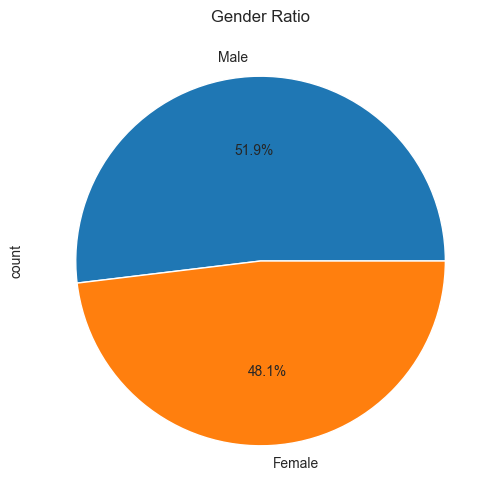

In [5]:
# Use original data for analysis
public_data = downloaded_publicdata.copy()

# Gender ratio
print("Gender Distribution:")
print(public_data['Gender'].value_counts())
public_data['Gender'].value_counts().plot(kind='pie', title='Gender Ratio',autopct='%1.1f%%')

# Discipline distribution
print("\nDiscipline Distribution:")
print(public_data['Discipline/Field'].value_counts())

# Linear Regression
This Linear Regression is a baseline model used in this research

Scatter plot for Linear Regression Evaluation:
R²: 0.6135598280516972


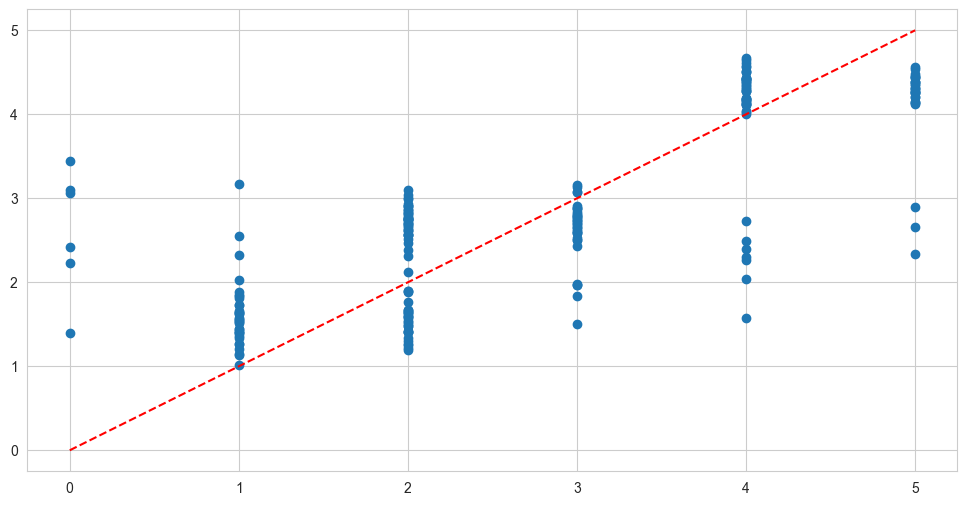

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

public_data = downloaded_publicdata.copy()
df_model = public_data.copy()

X = df_model.drop('depression', axis=1)
y = df_model['depression']

label_encoders = {}
categorical_columns = ['Gender','Year of Study','Discipline/Field','Age']

for column in public_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    public_data[column] = le.fit_transform(public_data[column].astype(str))
    label_encoders[column] = le

# Simple Linear Regression without encoding
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Use ONLY numeric columns (temporary fix)
df_numeric = public_data.select_dtypes(include=['number'])

X = df_numeric.drop('academic_performance', axis=1)
y = df_numeric['academic_performance']

# Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linearRegression_model = LinearRegression()
linearRegression_model.fit(X_train, y_train)
y_predict = linearRegression_model.predict(X_test)
print("Scatter plot for Linear Regression Evaluation:")
print('R²:', r2_score(y_test, y_predict))

# Plot
plt.scatter(y_test, y_predict)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

# Decision Tree Regressor

DECISION TREE: PREDICTING ACADEMIC PERFORMANCE

Original dataset shape: (1100, 18)
Columns: ['Age', 'Gender', 'Year of Study', 'Discipline/Field', 'anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure']

Target Variable: academic_performance
Number of Features: 13
Features: ['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure']

Features (X) shape: (1100, 13)
Target (y) shape: (1100,)

Training set: 880 students
Test set: 220 students

--------------------------------------------------------------------------------
TRAINING DECISION TREE MODEL
----------------------------------------------------------------------

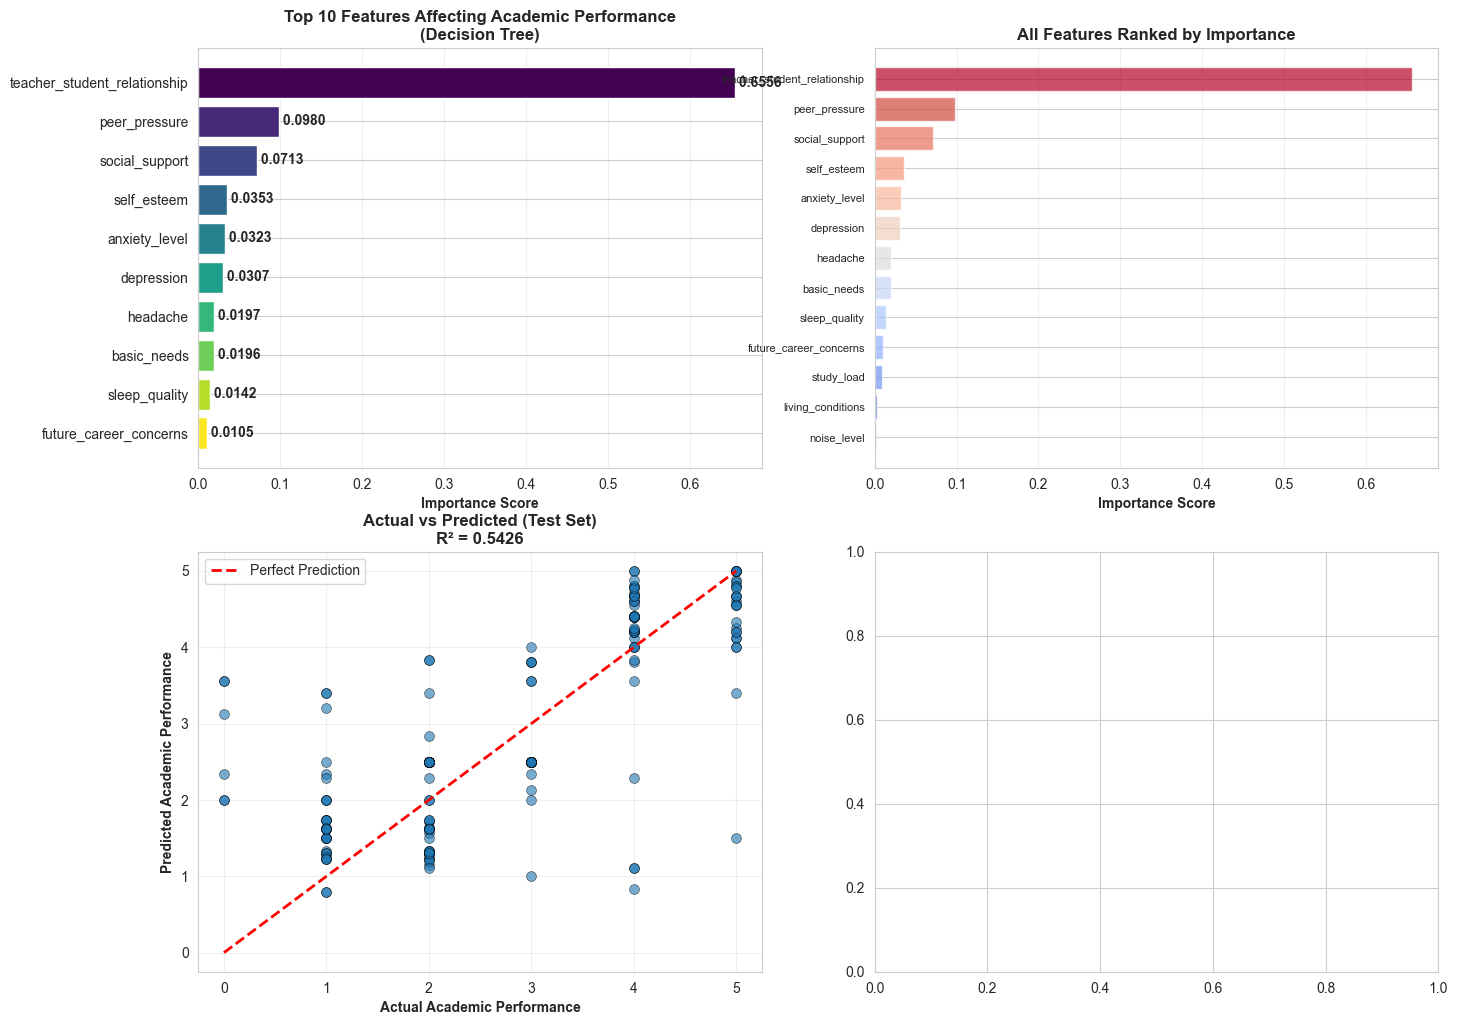

In [10]:
# Decision Tree regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

print("="*80)
print("DECISION TREE: PREDICTING ACADEMIC PERFORMANCE")
print("="*80)

# Step 1: Prepare clean data
public_data = downloaded_publicdata.copy()
df = public_data.copy()

print(f"\nOriginal dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Step 2: Define target and features CLEARLY
target = 'academic_performance'  # What you're predicting

# Features to EXCLUDE (demographic + target itself)
exclude_features = ['Age', 'Year of Study', 'Gender', 'Discipline/Field', target]

# Get all wellbeing factor features
all_features = [col for col in df.columns if col not in exclude_features]

print(f"\nTarget Variable: {target}")
print(f"Number of Features: {len(all_features)}")
print(f"Features: {all_features}")

# Step 3: Create X and y BEFORE splitting
X = df[all_features].copy()
y = df[target].copy()

# Handle missing values
X = X.fillna(X.median())
y = y.fillna(y.median())

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape[0]} students")
print(f"Test set: {X_test.shape[0]} students")

# Step 5: Train Decision Tree
print("\n" + "-"*80)
print("TRAINING DECISION TREE MODEL")
print("-"*80)

decisionTree_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

decisionTree_model.fit(X_train, y_train)

# Step 6: Make predictions
y_train_predict = decisionTree_model.predict(X_train)
y_test_predict = decisionTree_model.predict(X_test)

# Step 7: Evaluate
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)
train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f"\nMODEL PERFORMANCE:")
print(f"  Training R²:   {train_r2:.4f}")
print(f"  Test R²:       {test_r2:.4f}")
print(f"  Training RMSE: {train_rmse:.4f}")
print(f"  Test RMSE:     {test_rmse:.4f}")

if test_r2 < 0:
    print("\n⚠️  WARNING: Negative R² indicates model is worse than baseline!")
elif test_r2 < 0.3:
    print("\n⚠️  Low R² suggests weak predictive relationships.")
elif test_r2 < 0.5:
    print("\n✓ Moderate predictive performance.")
else:
    print("\n✓ Good predictive performance!")

# Step 8: Save model
joblib.dump(decisionTree_model, 'dt_academic_performance.pkl')
print("\n✓ Model saved as 'dt_academic_performance.pkl'")

# Step 9: Feature Importance Analysis
print("\n" + "-"*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': decisionTree_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Step 10: Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance Bar Chart (Top 10)
ax1 = axes[0, 0]
top_10 = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10)))
ax1.barh(range(len(top_10)), top_10['Importance'], color=colors)
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10['Feature'])
ax1.set_xlabel('Importance Score', fontweight='bold')
ax1.set_title('Top 10 Features Affecting Academic Performance\n(Decision Tree)', 
              fontweight='bold', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_10.iterrows()):
    ax1.text(row['Importance'], i, f" {row['Importance']:.4f}", 
             va='center', fontweight='bold')

# 2. All Features Importance (sorted)
ax2 = axes[0, 1]
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=True)
colors_all = plt.cm.coolwarm(np.linspace(0, 1, len(feature_importance_sorted)))
ax2.barh(range(len(feature_importance_sorted)), 
         feature_importance_sorted['Importance'], 
         color=colors_all, alpha=0.7)
ax2.set_yticks(range(len(feature_importance_sorted)))
ax2.set_yticklabels(feature_importance_sorted['Feature'], fontsize=8)
ax2.set_xlabel('Importance Score', fontweight='bold')
ax2.set_title('All Features Ranked by Importance', fontweight='bold', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

# 3. Actual vs Predicted (Test Set)
ax3 = axes[1, 0]
ax3.scatter(y_test, y_test_predict, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Academic Performance', fontweight='bold')
ax3.set_ylabel('Predicted Academic Performance', fontweight='bold')
ax3.set_title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}', 
              fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(alpha=0.3)

# Step 11: Detailed Feature Analysis by Category
print("\n" + "-"*80)
print("FEATURE IMPORTANCE BY CATEGORY")
print("-"*80)

# Define categories
categories = {
    'Psychological': ['anxiety_level', 'self_esteem', 'depression'],
    'Physical': ['headache', 'sleep_quality'],
    'Social': ['social_support', 'peer_pressure'],
    'Environmental': ['noise_level', 'living_conditions', 'basic_needs'],
    'Academic': ['study_load', 'teacher_student_relationship', 'future_career_concerns']
}

category_importance = {}
for category, features in categories.items():
    available_features = [f for f in features if f in feature_importance['Feature'].values]
    if available_features:
        total_importance = feature_importance[
            feature_importance['Feature'].isin(available_features)
        ]['Importance'].sum()
        category_importance[category] = total_importance
        
        print(f"\n{category}:")
        for feat in available_features:
            imp = feature_importance[feature_importance['Feature'] == feat]['Importance'].values[0]
            print(f"  {feat:<35} {imp:.4f}")
        print(f"  {'TOTAL':<35} {total_importance:.4f}")

# Compare with Linear Regression
# print(f'Linear Regression R²: {r2_lr:.4f}')

# After running the main code, add this:
# target_new = 'depression'
# X_new = df[[col for col in all_features if col != target_new]]
# y_new = df[target_new]

# X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# decisionTree_depression = DecisionTreeRegressor(max_depth=10, random_state=42)
# decisionTree_depression.fit(X_train_new, y_train_new)

# print(f"Depression Model R²: {decisionTree_depression.score(X_test_new, y_test_new):.4f}")

# # Feature importance
# importance_dep = pd.DataFrame({
#     'Feature': X_new.columns,
#     'Importance': decisionTree_depression.feature_importances_
# }).sort_values('Importance', ascending=False)

# print("\nTop 5 factors affecting Depression:")
# print(importance_dep.head())

# Academic Performance: Top factor = study_load
# Depression: Top factor = social_support

# Random Forest Classifier

RANDOM FOREST: PREDICTING ACADEMIC PERFORMANCE

Original dataset shape: (1100, 18)

Target Variable: academic_performance
Number of Features: 13
Features: ['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure']

Features (X) shape: (1100, 13)
Target (y) shape: (1100,)

Training set: 880 students
Test set: 220 students

--------------------------------------------------------------------------------
TRAINING RANDOM FOREST MODEL
--------------------------------------------------------------------------------

Model Parameters:
Number of Trees: 100
Max Depth: 10
Min Samples Split: 10
Min Samples Leaf: 5

Training model... (this may take a few seconds)
✓ Training complete!

--------------------------------------------------------------------------------
MODEL PERFORMANCE
--------------------------------------------

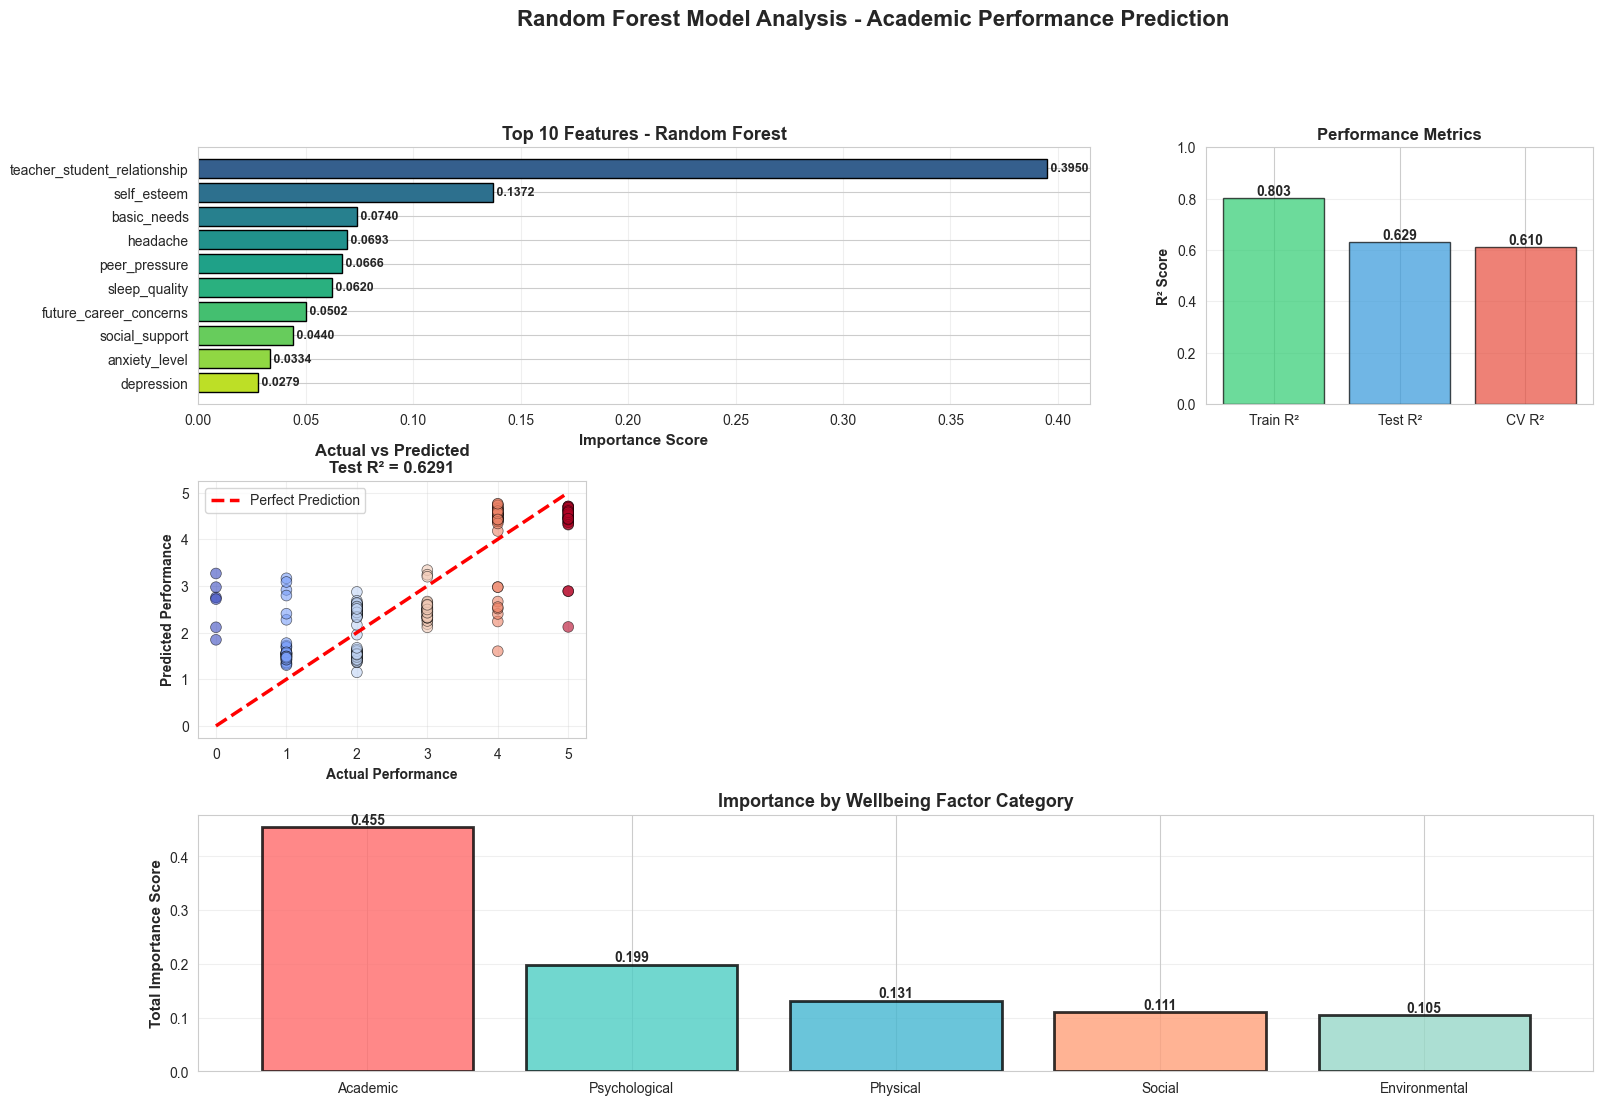


--------------------------------------------------------------------------------
FEATURE IMPORTANCE BY CATEGORY
--------------------------------------------------------------------------------

Psychological:
  anxiety_level                            0.0334
  self_esteem                              0.1372
  depression                               0.0279
  ────────────────────────────────────────────
  TOTAL                                    0.1986

Physical:
  headache                                 0.0693
  sleep_quality                            0.0620
  ────────────────────────────────────────────
  TOTAL                                    0.1314

Social:
  social_support                           0.0440
  peer_pressure                            0.0666
  ────────────────────────────────────────────
  TOTAL                                    0.1106

Environmental:
  noise_level                              0.0165
  living_conditions                        0.0142
  basic_needs

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("RANDOM FOREST: PREDICTING ACADEMIC PERFORMANCE")
print("="*80)

# Step 1: Prepare clean data
public_data = downloaded_publicdata.copy()
df = public_data.copy()

print(f"\nOriginal dataset shape: {df.shape}")

# Step 2: Define target and features
target = 'academic_performance'  # Change to 'depression' if needed

# Features to EXCLUDE (demographic + target)
exclude_features = ['Age', 'Year of Study', 'Gender', 'Discipline/Field', target]

# Get all wellbeing factor features
all_features = [col for col in df.columns if col not in exclude_features]

print(f"\nTarget Variable: {target}")
print(f"Number of Features: {len(all_features)}")
print(f"Features: {all_features}")

# Step 3: Create X and y
X = df[all_features].copy()
y = df[target].copy()

# Handle missing values
X = X.fillna(X.median())
y = y.fillna(y.median())

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape[0]} students")
print(f"Test set: {X_test.shape[0]} students")

# Step 5: Train Random Forest
print("\n" + "-"*80)
print("TRAINING RANDOM FOREST MODEL")
print("-"*80)

randomForest_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Maximum depth of each tree
    min_samples_split=10,  # Minimum samples to split a node
    min_samples_leaf=5,    # Minimum samples in leaf node
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)
print("\nModel Parameters:")
print(f"Number of Trees: 100")
print(f"Max Depth: 10")
print(f"Min Samples Split: 10")
print(f"Min Samples Leaf: 5")

print("\nTraining model... (this may take a few seconds)")
randomForest_model.fit(X_train, y_train)
print("✓ Training complete!")

# Step 6: Make predictions
y_train_predict = randomForest_model.predict(X_train)
y_test_predict = randomForest_model.predict(X_test)

# Step 7: Evaluate performance
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)
train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_predict)

print("\n" + "-"*80)
print("MODEL PERFORMANCE")
print("-"*80)
print(f"\nTraining Metrics:")
print(f"R² Score:  {train_r2:.4f}")
print(f"RMSE:      {train_rmse:.4f}")

print(f"\nTest Metrics:")
print(f"R² Score:  {test_r2:.4f}")
print(f"RMSE:      {test_rmse:.4f}")
print(f"MAE:       {test_mae:.4f}")

print(f"\nOverfitting Check:")
print(f"  Gap (Train R² - Test R²): {train_r2 - test_r2:.4f}")
if (train_r2 - test_r2) < 0.1:
    print("  ✓ Good generalization (minimal overfitting)")
elif (train_r2 - test_r2) < 0.2:
    print("  ⚠️ Slight overfitting (acceptable)")
else:
    print("  ⚠️ Significant overfitting (consider reducing complexity)")

# Cross-validation
print("\nPerforming 5-Fold Cross-Validation...")
cv_scores = cross_val_score(randomForest_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"  CV R² Scores: {cv_scores}")
print(f"  Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Step 8: Save model
joblib.dump(randomForest_model, 'rf_academic_performance.pkl')
print("\n✓ Model saved as 'rf_academic_performance.pkl'")

# Step 9: Feature Importance Analysis
print("\n" + "-"*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': randomForest_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:<40} {row['Importance']:.4f}")

# Check for demographic features (shouldn't be there)
problematic = ['Age', 'Gender', 'Year of Study', 'Discipline/Field']
found_problematic = [f for f in problematic if f in feature_importance['Feature'].values]
if found_problematic:
    print(f"\n⚠️ WARNING: Found demographic features: {found_problematic}")
else:
    print("\n✓ No demographic features (correct!)")

# Step 10: Comprehensive Visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top 10 Feature Importance
ax1 = fig.add_subplot(gs[0, :2])
top_10 = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_10)))
bars = ax1.barh(range(len(top_10)), top_10['Importance'], color=colors, edgecolor='black')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10['Feature'], fontsize=10)
ax1.set_xlabel('Importance Score', fontweight='bold', fontsize=11)
ax1.set_title('Top 10 Features - Random Forest', fontweight='bold', fontsize=13)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_10.iterrows()):
    ax1.text(row['Importance'], i, f" {row['Importance']:.4f}", 
             va='center', fontweight='bold', fontsize=9)

# 2. Model Performance Comparison
ax2 = fig.add_subplot(gs[0, 2])
metrics = ['Train R²', 'Test R²', 'CV R²']
values = [train_r2, test_r2, cv_scores.mean()]
colors_metrics = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax2.bar(metrics, values, color=colors_metrics, alpha=0.7, edgecolor='black')
ax2.set_ylabel('R² Score', fontweight='bold')
ax2.set_title('Performance Metrics', fontweight='bold', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Actual vs Predicted (Test Set)
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test, y_test_predict, alpha=0.6, s=60, c=y_test, 
            cmap='coolwarm', edgecolors='black', linewidth=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2.5, label='Perfect Prediction')
ax3.set_xlabel('Actual Performance', fontweight='bold')
ax3.set_ylabel('Predicted Performance', fontweight='bold')
ax3.set_title(f'Actual vs Predicted\nTest R² = {test_r2:.4f}', 
              fontweight='bold', fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(alpha=0.3)

# 6. Feature Importance by Category
ax6 = fig.add_subplot(gs[2, :])

categories = {
    'Psychological': ['anxiety_level', 'self_esteem', 'depression'],
    'Physical': ['headache', 'sleep_quality'],
    'Social': ['social_support', 'peer_pressure'],
    'Environmental': ['noise_level', 'living_conditions', 'basic_needs'],
    'Academic': ['study_load', 'teacher_student_relationship', 'future_career_concerns']
}

category_importance = {}
for category, features in categories.items():
    available_features = [f for f in features if f in feature_importance['Feature'].values]
    if available_features:
        total_importance = feature_importance[
            feature_importance['Feature'].isin(available_features)
        ]['Importance'].sum()
        category_importance[category] = total_importance

if category_importance:
    categories_sorted = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
    cat_names = [c[0] for c in categories_sorted]
    cat_values = [c[1] for c in categories_sorted]
    
    colors_cat = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    bars = ax6.bar(cat_names, cat_values, color=colors_cat, alpha=0.8, edgecolor='black', linewidth=2)
    ax6.set_ylabel('Total Importance Score', fontweight='bold', fontsize=11)
    ax6.set_title('Importance by Wellbeing Factor Category', fontweight='bold', fontsize=13)
    ax6.set_xticklabels(cat_names, rotation=0, fontsize=10)
    ax6.grid(axis='y', alpha=0.3)
    # Add value labels
    for bar, value in zip(bars, cat_values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Random Forest Model Analysis - Academic Performance Prediction', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Step 11: Detailed Category Analysis
print("\n" + "-"*80)
print("FEATURE IMPORTANCE BY CATEGORY")
print("-"*80)

for category, features in categories.items():
    available_features = [f for f in features if f in feature_importance['Feature'].values]
    if available_features:
        print(f"\n{category}:")
        category_total = 0
        for feat in available_features:
            imp = feature_importance[feature_importance['Feature'] == feat]['Importance'].values[0]
            category_total += imp
            print(f"  {feat:<40} {imp:.4f}")
        print(f"  {'─' * 44}")
        print(f"  {'TOTAL':<40} {category_total:.4f}")

# Step 12: Summary Report
print("\n" + "="*80)
# print("SUMMARY FOR RESEARCH PAPER")
print("="*80)

# Gradient Boosting

GRADIENT BOOSTING: PREDICTING ACADEMIC PERFORMANCE

Target: academic_performance
Features: 13
Training: 880 students
Test: 220 students

Training Gradient Boosting...
✓ Training complete!

RESULTS
Train R²:  0.9514
Test R²:   0.5623
CV R²:     0.5325 ± 0.1061
RMSE:      0.9040
MAE:       0.6688

✓ Model saved as 'gb_academic_performance.pkl'

TOP 10 IMPORTANT FEATURES
teacher_student_relationship             0.5472
peer_pressure                            0.1039
social_support                           0.0621
self_esteem                              0.0543
depression                               0.0474
anxiety_level                            0.0401
future_career_concerns                   0.0259
headache                                 0.0248
sleep_quality                            0.0221
noise_level                              0.0208


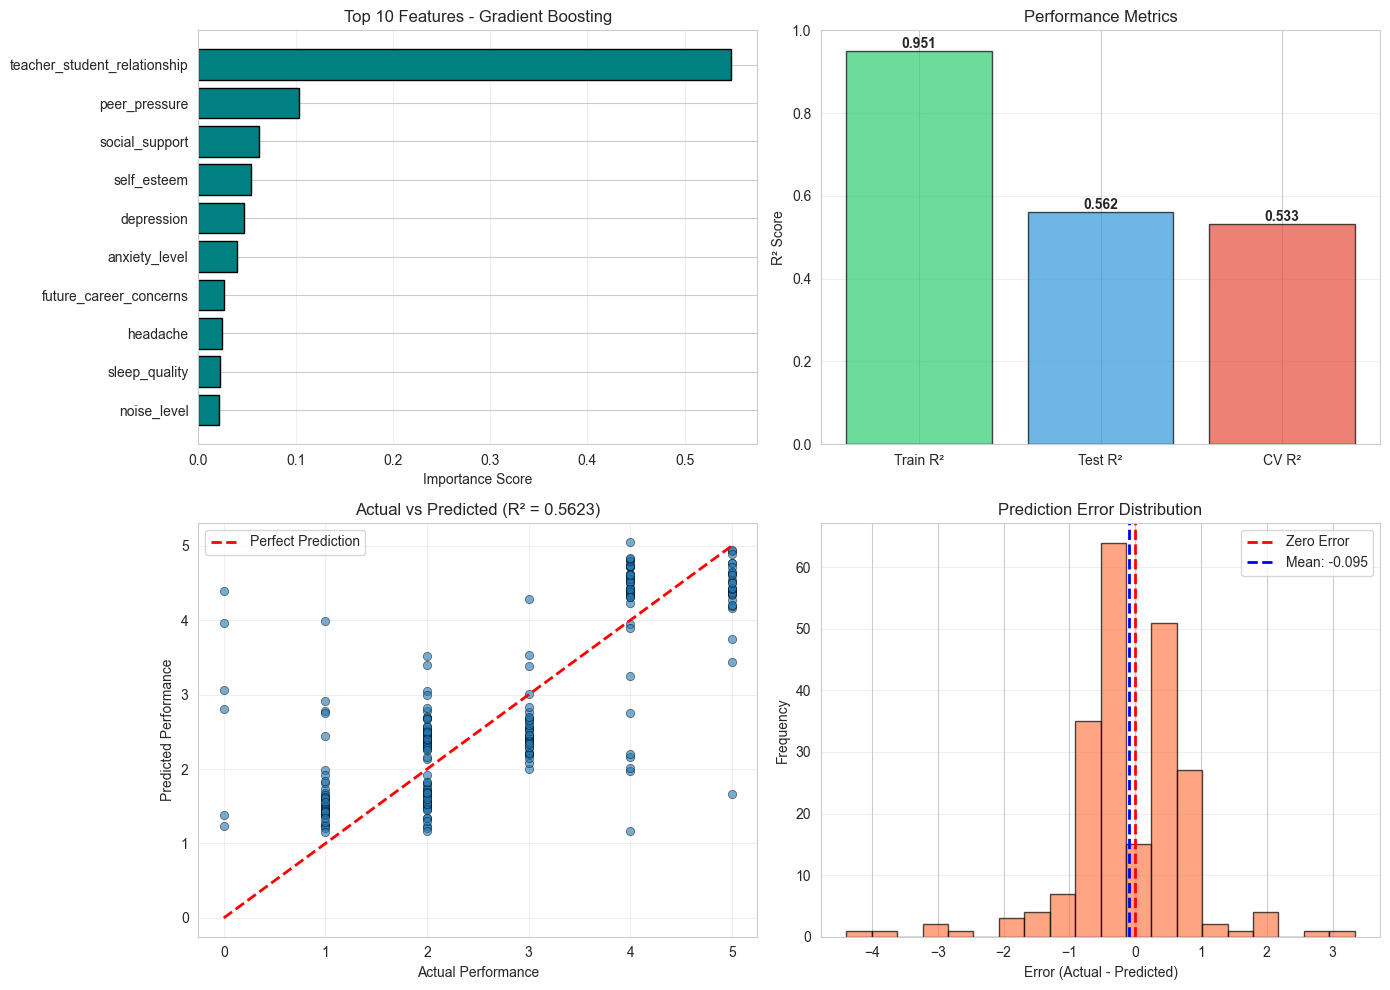


✓ Gradient Boosting Complete!


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
warnings.filterwarnings('ignore')

print("="*80)
print("GRADIENT BOOSTING: PREDICTING ACADEMIC PERFORMANCE")
print("="*80)
# Prepare data
public_data = downloaded_publicdata.copy()
df = public_data.copy()

# Define target and features
target = 'academic_performance'  # Change to 'depression' if needed
exclude_features = ['Age', 'Year of Study', 'Gender', 'Discipline/Field', target]
all_features = [col for col in df.columns if col not in exclude_features]

print(f"\nTarget: {target}")
print(f"Features: {len(all_features)}")

# Create X and y
X = df[all_features].fillna(df[all_features].median())
y = df[target].fillna(df[target].median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training: {len(X_train)} students")
print(f"Test: {len(X_test)} students")

# Train Gradient Boosting
print("\nTraining Gradient Boosting...")
gradientBoosting_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

gradientBoosting_model.fit(X_train, y_train)
print("✓ Training complete!")

# Predictions
y_train_predict = gradientBoosting_model.predict(X_train)
y_test_predict = gradientBoosting_model.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
test_mae = mean_absolute_error(y_test, y_test_predict)

# Cross-validation
cv_scores = cross_val_score(gradientBoosting_model, X_train, y_train, cv=5, scoring='r2')

print("\n" + "="*80)
print("RESULTS")
print("="*80)
print(f"Train R²:  {train_r2:.4f}")
print(f"Test R²:   {test_r2:.4f}")
print(f"CV R²:     {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"RMSE:      {test_rmse:.4f}")
print(f"MAE:       {test_mae:.4f}")

# Save model
joblib.dump(gradientBoosting_model, 'gb_academic_performance.pkl')
print("\n✓ Model saved as 'gb_academic_performance.pkl'")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gradientBoosting_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*80)
print("TOP 10 IMPORTANT FEATURES")
print("="*80)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['Feature']:<40} {row['Importance']:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Feature Importance
ax1 = axes[0, 0]
top_10 = feature_importance.head(10)
ax1.barh(range(len(top_10)), top_10['Importance'], color='teal', edgecolor='black')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10['Feature'])
ax1.set_xlabel('Importance Score')
ax1.set_title('Top 10 Features - Gradient Boosting')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Performance Metrics
ax2 = axes[0, 1]
metrics = ['Train R²', 'Test R²', 'CV R²']
values = [train_r2, test_r2, cv_scores.mean()]
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax2.bar(metrics, values, color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('R² Score')
ax2.set_title('Performance Metrics')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}',
             ha='center', va='bottom', fontweight='bold')

# 3. Actual vs Predicted
ax3 = axes[1, 0]
ax3.scatter(y_test, y_test_predict, alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Performance')
ax3.set_ylabel('Predicted Performance')
ax3.set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Error Distribution
ax4 = axes[1, 1]
errors = y_test - y_test_predict
ax4.hist(errors, bins=20, color='coral', edgecolor='black', alpha=0.7)
ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax4.axvline(errors.mean(), color='blue', linestyle='--', linewidth=2,
            label=f'Mean: {errors.mean():.3f}')
ax4.set_xlabel('Error (Actual - Predicted)')
ax4.set_ylabel('Frequency')
ax4.set_title('Prediction Error Distribution')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ Gradient Boosting Complete!")
print("="*80)

# XGBoost Regressor

In [157]:
# Support Vector Machine Classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

svm_model = SVC(kernel='linear', random_state=42)

public_data = downloaded_publicdata.copy()

# Train model
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, 'svm_public.pkl')

# Predict
y_predictsvm = svm_model.predict(X_test)

# Evaluate
print("SVM Accuracy: ", accuracy_score(y_test, y_predictsvm))
print("\nClassification Report: \n", classification_report(y_test, y_predictsvm))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_predictsvm))

SVM Accuracy:  0.11363636363636363

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.11      0.10      0.11        10
           2       0.00      0.00      0.00         6
           3       0.08      0.11      0.09         9
           4       0.25      0.20      0.22         5
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         6
           7       0.33      0.29      0.31         7
           8       0.17      0.20      0.18        10
           9       0.25      0.14      0.18        14
          10       0.40      0.22      0.29        18
          11       0.14      0.11      0.12         9
          12       0.11      0.33      0.17         6
          13       0.29      0.50      0.37        10
          14       0.14      0.11      0.12         9
          15       0.00      0.00      0.00         7
          16       0

## Comparison

                      Model  Accuracy
0            Decision Tree   0.872727
1            Random Forest   0.881818
2      Logistic Regression   0.895455
3   Support Vector Machine   0.909091


Text(0.5, 1.0, 'Model Comparison')

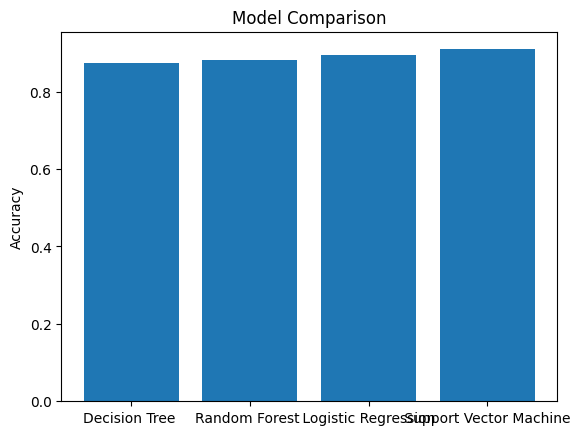

In [144]:
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Store results
results = {
    "Decision Tree ": decisionTree_model.score(X_test, y_test),
    "Random Forest ": randomForest_model.score(X_test, y_test),
    " Logistic Regression ": logisticRegression_model.score(X_test, y_test),
    " Support Vector Machine ": svm_model.score(X_test, y_test)
}

results_dataframe = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print(results_dataframe)

public_data = downloaded_publicdata.copy()

plt.bar(results.keys(), results.values())
plt.ylabel("Accuracy")
plt.title("Model Comparison")

# Survey Responses
# Load + Drop columns Data Preprocessing

In [184]:
# import pandas as pd

# public_data = downloaded_publicdata.copy()

# survey_data = pd.read_csv("Responses_renamed.csv")

# print(survey_data.head())

# print("Columns till here of public data: ")
# print(public_data.columns.tolist())

  Total score      Age Age [Score]  Age [Feedback]  Gender Gender [Score]  \
0    0.00 / 0  20 - 22      -- / 0             NaN    Male         -- / 0   
1    0.00 / 0  23 - 25      -- / 0             NaN  Female         -- / 0   
2    0.00 / 0  23 - 25      -- / 0             NaN    Male         -- / 0   
3    0.00 / 0  23 - 25      -- / 0             NaN    Male         -- / 0   
4    0.00 / 0  20 - 22      -- / 0             NaN    Male         -- / 0   

   Gender [Feedback] Year of Study Year of Study [Score]  \
0                NaN   Second Year                -- / 0   
1                NaN   Fourth Year                -- / 0   
2                NaN    First Year                -- / 0   
3                NaN   Fourth Year                -- / 0   
4                NaN   Second Year                -- / 0   

   Year of Study [Feedback]  ... basic_needs.2 study_load  study_load.1  \
0                       NaN  ...           NaN          2        -- / 0   
1                       Na

In [188]:
# # Clean and preprocess the data

# survey_data = survey_data.drop(columns=['Timestamp'], errors='ignore')
# survey_data["Discipline/Field"] = survey_data["Discipline/Field"].str.upper().str.strip()

# survey_data["Discipline/Field"] = survey_data["Discipline/Field"].replace({
#     "BSCS": "CS",
#     "Cs": "CS",
#     "CS": "CS",
#     "Computer Science": "CS"
# })
# survey_data.to_csv("Responses_updated.csv", index=False)

# print("Columns")
# print(survey_data.columns)
# # print(df.head())

# survey_data["Year of Study"] = survey_data["Year of Study"].str.strip()

# survey_data["Year of Study"] = survey_data["Year of Study"].replace({
#     "3rd Semester": "Second Year"
# })
# df_reduced = df.iloc[:, 1000:]
# df_reduced.to_csv("Reduced_AcademicStressResponses.csv", index=False)

# print("Columns dropped. New shape:", df_reduced.shape)

# print(survey_data.head())

# Create mapping dictionary
# columns_mapping = {
#     'What is your anxiety level before exams or academic presentations?': 'anxiety_level',
#     'How do you rate your self-esteem while handling academic challenges?': 'self_esteem', 
#     'How often do you feel depressed during your studies?': 'depression',
#     'I experience physical symptoms (headache, stomachache) before exams or presentations': 'headache',
#     'I push myself to meet the deadlines even when it negatively affects my sleep quality or health': 'sleep_quality',
#     'Background noise distracts me during study.': 'noise_level',
#     'Poor lighting in my room or home study area makes my living conditions for studying harder.': 'living_conditions',
#     'Lack of basic needs (water, electricity, and internet) causes me stress during studies.': 'basic_needs',
#     'How heavy is your study load when maintaining a CGPA?': 'study_load',
#     'I feel my relationship with teachers is affected by my lower grades.': 'teacher_student_relationship',
#     'I worry that low grades may negatively affect my future career.': 'future_career_concerns',
#     'How supportive are your family and friends in your studies?': 'social_support',
#     'How often do you feel pressured by your classmates or peers about your academic performance?': 'peer_pressure'
# }

# # Rename columns
# for old_col in survey_data.columns:
#     for key, new_col in columns_mapping.items():
#         if key in old_col:  # partial match
#             survey_data.rename(columns={old_col: new_col}, inplace=True)
# surveycolumns_renamed = survey_data.rename(columns=columns_mapping, inplace=True)

# df.columns = [
#     'Total score', 'Age', 'Gender', 'Year of Study', 'Discipline/Field',
#     'anxiety_level', 'depression', 'self_esteem', 'headache', 'sleep_quality',
#     'social_support', 'peer_pressure', 'noise_level', 'living_conditions',
#     'basic_needs', 'study_load', 'teacher_student_relationship', 'future_career_concerns'
# ]
# # Save to new CSV
# survey_data.to_csv('Responses_renamed.csv', index=False)

# # Then use this renamed file
# survey_data = pd.read_csv('Responses_renamed.csv')

# print("Public data: ")
# print(public_data.columns.tolist())

# print("AFTER RENAMING:_______")
# print(survey_data.columns)

Columns
Index(['Total score', 'Age', 'Age [Score]', 'Age [Feedback]', 'Gender',
       'Gender [Score]', 'Gender [Feedback]', 'Year of Study',
       'Year of Study [Score]', 'Year of Study [Feedback]', 'Discipline/Field',
       'Discipline/Field [Score]', 'Discipline/Field [Feedback]',
       'anxiety_level', 'anxiety_level.1', 'anxiety_level.2', 'depression',
       'depression.1', 'depression.2', 'self_esteem', 'self_esteem.1',
       'self_esteem.2', 'headache', 'headache.1', 'headache.2',
       'sleep_quality', 'sleep_quality.1', 'sleep_quality.2', 'social_support',
       'social_support.1', 'social_support.2', 'peer_pressure',
       'peer_pressure.1', 'peer_pressure.2', 'noise_level', 'noise_level.1',
       'noise_level.2', 'living_conditions', 'living_conditions.1',
       'living_conditions.2', 'basic_needs', 'basic_needs.1', 'basic_needs.2',
       'study_load', 'study_load.1', 'study_load.2',
       'teacher_student_relationship', 'teacher_student_relationship.1',
      

# Applying models

In [107]:
# Loading trained models
# import joblib
# import pandas as pd

# decisionTree_model = joblib.load('dt_public.pkl')
# randomForest_model = joblib.load('rf_public.pkl')
# logisticRegression_model = joblib.load('lr_public.pkl')
# svm_model = joblib.load('svm_public.pkl')


# 3) Choose features (wearable-measurable / proxy)

Use only features that can be collected from wearables / phone sensors. If you also have raw high-frequency signals (HR, accel) you should create windowed summary features — I provide a short note below for that.

In [14]:
# Keep these if present
feature_candidates = [c for c in [
    'blood_pressure','sleep_quality','breathing_problem','noise_level',
    'headache','anxiety_level','depression','stress_level'  # careful: these might be labels; include only as features if you intend
] if c in df.columns]

# Typically, don't use anxiety/depression/stress as input features if they're your labels.
# So remove them from features if they appear in targets
for t in ['anxiety_level','depression','stress_level']:
    if t in feature_candidates and ('target_psych' in targets or 'target_env' in targets):
        feature_candidates.remove(t)

X = df[feature_candidates].copy()
y = df[targets].copy()

print("Features:", X.columns.tolist())
print("y shape:", y.shape)


Features: ['blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'headache']
y shape: (1100, 3)


# 4) Preprocess + model pipeline (baseline)

We’ll use a robust baseline: MultiOutputClassifier(RandomForest). Use GroupKFold if you have subject_id column — avoids leakage.

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import f1_score, hamming_loss, roc_auc_score

# Imputer & scaler (scaler optional for tree models)
preproc = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

X_prep = preproc.fit_transform(X)

clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42))

# Choose cross-validator: group-wise if possible
if 'subject_id' in df.columns:
    groups = df['subject_id']
    cv = GroupKFold(n_splits=5)
    preds = cross_val_predict(clf, X_prep, y, cv=cv, groups=groups, method='predict')
else:
    # fallback to 5-fold; for multi-label ideally use subject split or iterative stratification
    from sklearn.model_selection import StratifiedKFold
    # create a simple stratifier by first label (approx)
    strat_col = y.iloc[:,0] if y.shape[1]>0 else None
    cv = 5
    preds = cross_val_predict(clf, X_prep, y, cv=cv, method='predict')

preds = pd.DataFrame(preds, columns=y.columns, index=y.index)


# 5) Evaluation (multi-label metrics)

In [16]:
def eval_multi(y_true, y_pred):
    print("Hamming loss:", hamming_loss(y_true, y_pred))
    print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
    print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
    # per-label F1
    for col in y_true.columns:
        print(col, "F1:", f1_score(y_true[col], y_pred[col]))

eval_multi(y, preds)


Hamming loss: 0.07363636363636364
Micro F1: 0.9328543796628903
Macro F1: 0.9347678149556465
target_psych F1: 0.8170829975825947
target_phys F1: 0.987220447284345
target_env F1: 1.0


# 6) Better: predict probabilities + tune per-label threshold

Default threshold=0.5 is not always best. We'll get probabilities (with an actual train/val split) and choose threshold per label maximizing F1.

In [17]:


# train-test split (group-aware if possible)
if 'subject_id' in df.columns:
    # simple group split
    unique_groups = df['subject_id'].unique()
    train_groups, val_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)
    train_idx = df['subject_id'].isin(train_groups)
    val_idx = df['subject_id'].isin(val_groups)
else:
    train_idx, val_idx = train_test_split(df.index, test_size=0.2, random_state=42)

X_tr, X_val = X_prep[train_idx], X_prep[val_idx]
y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

clf.fit(X_tr, y_tr)
probas = clf.predict_proba(X_val)  # list of arrays, one per label

# get best threshold per label
best_thresh = {}
y_pred_thresh = np.zeros_like(y_val.values)
for i, col in enumerate(y_val.columns):
    # predict_proba returns (n_samples, 2) for binary; take column 1
    p = probas[i][:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_val.iloc[:,i], p)
    f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-9)
    best_idx = np.nanargmax(f1_scores)
    # threshold array is one shorter than precisions; handle edge
    if best_idx >= len(thresholds):
        thr = 0.5
    else:
        thr = thresholds[best_idx]
    best_thresh[col] = float(thr)
    y_pred_thresh[:, i] = (p >= thr).astype(int)

y_pred_thresh = pd.DataFrame(y_pred_thresh, columns=y_val.columns, index=y_val.index)
eval_multi(y_val, y_pred_thresh)
print("Chosen thresholds per label:", best_thresh)


Hamming loss: 0.06666666666666667
Micro F1: 0.9385474860335196
Macro F1: 0.9458573172858887
target_psych F1: 0.8498168498168498
target_phys F1: 0.9877551020408163
target_env F1: 1.0
Chosen thresholds per label: {'target_psych': 0.14532842157842157, 'target_phys': 0.525, 'target_env': 0.935}
